In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from MemSE.train_test_loop import accuracy
from MemSE.utils import count_parameters
from MemSE.model_load import load_model
from MemSE.dataset import get_dataloader
from MemSE.network_manipulations import conv_to_fc
from MemSE.MemSE import MemSE
from MemSE.MemristorQuant import MemristorQuant

device = torch.device('cpu')

train_loader, valid_loader, test_loader, nclasses, input_shape = get_dataloader('CIFAR10', bs=4)
criterion = nn.CrossEntropyLoss().to(device)
model = load_model('smallest_vgg', nclasses).to(device)
print(count_parameters(model))
model = conv_to_fc(model, input_shape).to(device)
print(count_parameters(model))
batch, target = next(iter(valid_loader))
batch, target = batch.to(device), target.to(device)
original_output = model(batch)
original_acc = accuracy(original_output, target)
print(f'Original acc is {original_acc}')


quanter = MemristorQuant(model)
quanter.quant()
quanted_output = model(batch)
quanted_acc = accuracy(quanted_output, target)
print(f'Quanted acc is {quanted_acc}')

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading model checkpoint
4030
8061088
Original acc is [tensor(75.)]
Quanted acc is [tensor(25.)]


In [2]:
memse = MemSE(model, quanter, input_bias=None)
mses = memse.mse_forward(batch)

In [3]:
mses

{'sim': {torch.nn.modules.linear.Linear: {0: array(10205633., dtype=float32),
   3: array(2.7202143e+12, dtype=float32),
   6: array(3.630482e+17, dtype=float32),
   9: array(2.3978916e+22, dtype=float32),
   12: array(8.20979e+26, dtype=float32),
   15: array(6.5632474e+30, dtype=float32)},
  torch.nn.modules.activation.Softplus: {1: array(5093526., dtype=float32),
   4: array(1.3499968e+12, dtype=float32),
   7: array(1.7982765e+17, dtype=float32),
   10: array(1.2075158e+22, dtype=float32),
   13: array(3.949026e+26, dtype=float32)},
  torch.nn.modules.pooling.AvgPool2d: {2: array(2485148., dtype=float32),
   5: array(6.601119e+11, dtype=float32),
   8: array(8.699321e+16, dtype=float32),
   11: array(5.9800445e+21, dtype=float32),
   14: array(1.8912285e+26, dtype=float32)}},
 'us': {torch.nn.modules.linear.Linear: {0: array(1021.0253, dtype=float32),
   3: array(26879.363, dtype=float32),
   6: array(492960.62, dtype=float32),
   9: array(3549650., dtype=float32),
   12: array(335

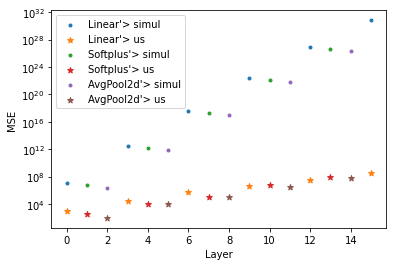

In [4]:
for type_, sub_dict in mses['sim'].items():
    us_sub_dict = mses['us'].get(type_)
    plt.scatter(sub_dict.keys(), sub_dict.values(), marker='.', label=str(type_).split('.')[-1]+' simul')
    plt.scatter(us_sub_dict.keys(), us_sub_dict.values(), marker='*', label=str(type_).split('.')[-1]+' us')
plt.legend()
plt.yscale('log')
plt.xlabel('Layer')
plt.ylabel('MSE')
plt.show()